<a href="https://colab.research.google.com/github/Mauricio-Sousa-Araujo/MC886Trabalho01/blob/master/trabalho_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho Final MC886

Para o trabalho final iremos criar uma rede que seja capaz de gerar sentence embeddings, iremos testa-la com o Quora Question Pair dataset. A tarefa de teste consiste em dizer se duas perguntas são iguais ou não.
Iremos comparar esses resultados com os obtidos pelo universal sentence encoder.

## Treinando os word embeddings

Como primeiro passo iremos treinar uma rede para gerar word embeddings específicos para nosso domínio. Testaremos duas ideias: gerar os embeddings do zero e gerar os embeddings a partir de embeddings já existentes (word2vec/glove)

In [ ]:
#Comando para ler o dataset do google drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import zipfile
import csv
import numpy as np
import spacy  # For preprocessing
import multiprocessing
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


In [ ]:
def loadData(arquivo,data):
#Recebe o nome(arquivo) do zip e o nome do arquivo dentro do zip(data)
#Retorna um objeto pandas
  with zipfile.ZipFile(arquivo, 'r') as zip: 
      # printing all the contents of the zip file 
      zip.printdir()    
      # extracting all the files 
      print('Extracting all the files now...') 
      zip.extractall() 
      print('Done!') 
  with open(data) as f:
      df = pd.read_csv(data)
  return df

In [ ]:
#Coloque o diretório correto depois de 'drive'
arquivo='/content/drive/My Drive/Colab Notebooks/question-pairs-dataset.zip'
data="questions.csv"
df=loadData(arquivo,data)
df.tail()


File Name                                             Modified             Size
questions.csv                                  2019-09-20 06:55:00     60747409
Extracting all the files now...
Done!


,id,qid1,qid2,question1,question2,is_duplicate
404346,404346,789792,789793,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404347,404347,789794,789795,Do you believe there is life after death?,Is it true that there is life after death?,1
404348,404348,789796,789797,What is one coin?,What's this coin?,0
404349,404349,789798,789799,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0
404350,404350,789800,789801,What is like to have sex with cousin?,What is it like to have sex with your cousin?,0


In [ ]:
#Separamos 80% para treino, 10% validação e 10% para teste
def splitData(df,per):
  size=int(df.shape[0]*per)
  return df[:size], df[size:]
q_train,q_test=splitData(df.values,0.8)
q_test,q_val=splitData(q_test,0.5)

In [ ]:
#Colocamos todas frases em array para treinar para Word2vec
frases_train=np.hstack((q_train[:,3],q_train[:,4]))
frases_train

array(['What is the step by step guide to invest in share market in india?',
       'What is the story of Kohinoor (Koh-i-Noor) Diamond?',
       'How can I increase the speed of my internet connection while using a VPN?',
       ..., 'Will the BJP win in the UP assembly elections in 2017?',
       'How can Modi government prevent black money by discontinuing 500 and 1000 notes?',
       'What is an overrated overrating?'], dtype=object)

In [ ]:
def cleaning(doc):
    # Lematizamos e removemos stopWords  e pontuação
    #Removemos stopWords, pois eles não tem tanta importância para o modelo.
    #A ideia por trás de lematizar é basicamente  ficar com as raízes das palavras.
    # Por exemplo,se temos as palavras 'encontraram' e 'encontrará', ficaremos com a palavra encontrar em ambos os casos.
    #Lematizamos apenas para simplificar o modelo
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not (token.is_stop or token.is_punct)]
    return ' '.join(txt)
def processaData(frases):
    nlp = spacy.load('en', disable=['ner', 'parser']) # desabilitamos Named Entity Recognition e importamos o modelo
    brief_cleaning = [( str(row)).lower() for row in frases]
    #Processamos o data
    txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]
    return txt

t = time()
frases_train_p=processaData(frases_train)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))
frases_train_p[:10]


Time to build vocab: 8.09 mins


['step step guide invest share market india',
 'story kohinoor koh noor diamond',
 'increase speed internet connection vpn',
 'mentally lonely solve',
 'dissolve water quikly sugar salt methane carbon di oxide',
 'astrology capricorn sun cap moon cap rise',
 'buy tiago',
 'good geologist',
 'use シ instead し',
 'motorola company hack charter motorolla dcx3400']

In [ ]:
#Transformamos em bigrams para facilitar o precessamento
from gensim.models.phrases import Phrases, Phraser
sent = [row.split() for row in frases_train_p]
phrases = Phrases(sent, min_count=20, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]


In [ ]:
def cosineSimlarity(vec1,vec2):
  #Calula a similaridade entre duas frases/vetores pela métrica cosseno
  return cosine_similarity( vec1.reshape(1, -1), vec2.reshape(1, -1) )
def mediaWordVectors(frase,wv_model):
  #Calcula a média de uma frase
  count=0
  output=np.zeros(300)
  aux =str(frase).split() 
  for word in aux:
    #ignoramos as palavras que não estão no vocabulário
    if word in wv_model.vocab:
     count=count+1
     output=wv_model.get_vector(word)  +output
  if( count>1):
    return output/count
  else: 
    return output
def acuracyAndErroQuadratico(data,lowerLimit , wv_model):
  #Por padrão, o data terá por linha duas frases e um número avisando se é similar(1) ou nao(0)
  acuracia=0
  erro=0
  for linha in data:
    aux=cosineSimlarity(   mediaWordVectors(linha[0],wv_model) , mediaWordVectors(linha[1],wv_model)   )
    erro=(linha[2]-aux)**2+erro
    if(aux>=lowerLimit):
      aux=1
    else: aux=0
    if(linha[2]==aux):
      acuracia=acuracia+1
  return acuracia/data.shape[0], erro/data.shape[0]




In [ ]:
#Apenas processamos os dados para deixar as palavras legíveis, ou seja,
#Frases como "how are you?" ficará "how are you ?", pois caso contrário ele pode interpretar  "you?" como uma palavra 
t = time()
data_all=[]

data_test=q_test[:,3:].copy()
data_val=q_val[:,3:].copy()
data_train=q_train[:,3:].copy()

data_all.append(data_test)
data_all.append(data_val)
data_all.append(data_train)

nlp = spacy.load('en', disable=['ner', 'parser']) # desabilitamos Named Entity Recognition e importamos o modelo
for data in data_all:
  for linha in data:
    linha[0]=' '.join([token.orth_ for token in nlp( str(linha[0]).lower() ) ])
    linha[1]=' '.join([token.orth_ for token in nlp( str(linha[1]).lower() ) ])
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))



Time to build vocab: 32.22 mins


In [ ]:
#Importamos o modelo 'word2vec-google-news-300' apenas para comparação
import gensim.downloader as api
wv_model = api.load('word2vec-google-news-300')

[=====================================-------------] 74.2% 1234.3/1662.8MB downloadedBuffered data was truncated after reaching the output size limit.

In [ ]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
w2v_model = Word2Vec(min_count=20,# frequência mínima de uma palavra no corpus que será considerada no modelo
                     window=2,#Quantidade de palavras a direita e a esquerda de uma palavra central
                     size=300,#Quantidade de neurônios na camada escondida
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1,
                     sg=1)#Setamos um para utilizarmos o molode skip-gram

t = time()
#Construímos o vocabulário
w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))


Time to build vocab: 0.2 mins


In [ ]:
t = time()
acu_train=[]
err_train=[]
acu_val=[]
err_val=[]
n_ep=10
#Treinamos o modelo por 10 épocas e guardamos o erro e a acurácia para cada época
for ep in range(n_ep):
  w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=ep, report_delay=1)
  w2v_model.init_sims(replace=True)
  a,e=acuracyAndErroQuadratico(data_train,0.75 , w2v_model.wv)
  acu_train.append(a)
  err_train.append(e)
  a,e=acuracyAndErroQuadratico(data_val,0.75 , w2v_model.wv)
  acu_val.append(a)
  err_val.append(e)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 23.66 mins


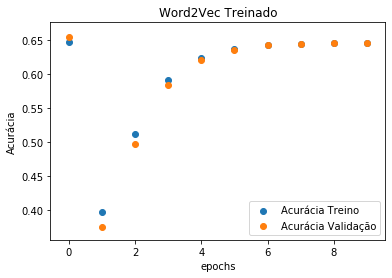

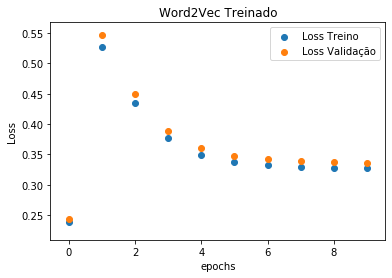

In [ ]:
#Plotamos os resultados
X=np.arange(n_ep)
fig, axs = plt.subplots()
axs.scatter(X,acu_train, label='Acurácia Treino')
axs.scatter(X,acu_val,label='Acurácia Validação')
axs.set(xlabel='epochs')
axs.set(ylabel='Acurácia')
axs.set_title("Word2Vec Treinado")
axs.legend()

fig, axs = plt.subplots()
axs.scatter(X,err_train, label='Loss Treino')
axs.scatter(X,err_val,label='Loss Validação')
axs.set(xlabel='epochs')
axs.set(ylabel='Loss')
axs.set_title("Word2Vec Treinado")
axs.legend()

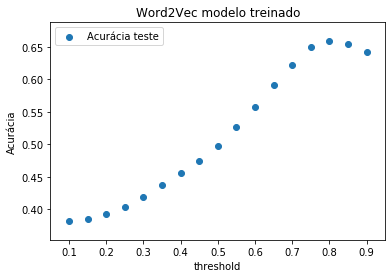

In [ ]:
#Iremos verificar qual é o melhor threshold para maxizar o valor da acurácia para o modelo treinado do zero
#Note que nesse caso threshold=limit
limit=0.1
err_test=[]
acu_test=[]
limits=[]
while( limit<0.95):
  limits.append(limit)
  a,e=acuracyAndErroQuadratico(data_test,limit,w2v_model.wv)
  err_test.append(e)
  acu_test.append(a)
  limit=limit+0.05
#Plotamos os resultados
fig, axs = plt.subplots()
axs.scatter(limits,acu_test, label='Acurácia teste')
axs.set(xlabel='threshold')
axs.set(ylabel='Acurácia')
axs.set_title("Word2Vec modelo treinado")
axs.legend()

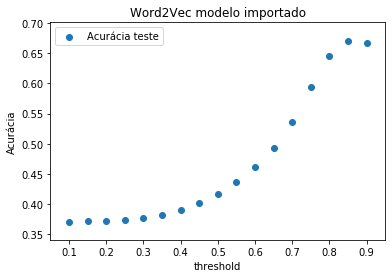

In [ ]:
#Iremos verificar qual é o melhor threshold para maxizar o valor da acurácia para o modelo importado
limit=0.1
err_test2=[]
acu_test2=[]
limits=[]
while( limit<0.95):
  limits.append(limit)
  a,e=acuracyAndErroQuadratico(data_test,limit,wv_model)
  err_test2.append(e)
  acu_test2.append(a)
  limit=limit+0.05
#Plotamos os resultados
fig, axs = plt.subplots()
axs.scatter(limits,acu_test2, label='Acurácia teste')
axs.set(xlabel='threshold')
axs.set(ylabel='Acurácia')
axs.set_title("Word2Vec modelo importado")
axs.legend()

## Abordagem com redes neurais

Abordagem usando duas biLSTM's siamases e word embeddings como entrada.

Abordagem usando duas biLSTMs siamesas e rede classicador

Abordagem com USE e rede classificadora

Para rodar basta colocar o arquivo 'questions.csv' na raiz do projeto e rodar o código em ordem

In [ ]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2019-12-06 22:10:36--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.136.13
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.136.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  45.8MB/s    in 26s     

2019-12-06 22:11:03 (60.5 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
!gunzip /content/GoogleNews-vectors-negative300.bin.gz
# !unzip /content/crawl-300d-2M-subword.zip

In [ ]:
TASK_DATA_DIR = 'glue_data/QQP'
!test -d glue_data || git clone https://gist.github.com/60c2bdb54d156a41194446737ce03e2e.git glue_data
!test -d $TASK_DATA_DIR || python glue_data/download_glue_data.py --data_dir glue_data --tasks=QQP
!ls -als $TASK_DATA_DIR

Cloning into 'glue_data'...
remote: Enumerating objects: 21, done.
remote: Total 21 (delta 0), reused 0 (delta 0), pack-reused 21
Unpacking objects: 100% (21/21), done.
	Completed!
total 106400
    4 drwxr-xr-x 3 root root     4096 Dec  6 22:11 .
    4 drwxr-xr-x 4 root root     4096 Dec  6 22:11 ..
 5680 -rw-r--r-- 1 root root  5815716 Dec  6 22:11 dev.tsv
    4 drwxr-xr-x 2 root root     4096 Dec  6 22:11 original
49572 -rw-r--r-- 1 root root 50759408 Dec  6 22:11 test.tsv
51136 -rw-r--r-- 1 root root 52360463 Dec  6 22:11 train.tsv


In [ ]:
!pip3 install tensorflow-gpu==1.13.1
!pip3 install tf-sentencepiece
!pip3 install sentencepiece

     |████████████████████████████████| 345.2MB 44kB/s 
     |████████████████████████████████| 368kB 59.9MB/s 
     |████████████████████████████████| 3.2MB 39.4MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 1.13.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 1.13.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
     |████████████████████████████████| 2.7MB 2.8MB/s 
     |████████████████████████████████| 1.0MB 2.8MB/s 


### Preparando os dados

In [ ]:
from numpy.random import seed
seed(1)
import tensorflow as tf
import sentencepiece
import tf_sentencepiece
import tensorflow_hub as hub
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import nltk
nltk.download('stopwords')

from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from gensim.models.fasttext import FastText
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Input, Embedding, LSTM, Lambda, dot, Bidirectional, concatenate, Dense, Dropout, BatchNormalization
import keras.backend as K
from keras.optimizers import Adadelta, Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

Found GPU at: /device:GPU:0
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


In [ ]:
TRAIN_PATH = './questions.csv'
TEST_PATH = './glue_data/QQP/test.tsv'
EMBEDDINGS_PATH = './GoogleNews-vectors-negative300.bin'
questions_cols = ['question1', 'question2']

In [ ]:
train_df = pd.read_csv(TRAIN_PATH)

train_df.sample(frac=1).reset_index(drop=True)
keys = ['question1', 'question2', 'is_duplicate']
train_df = train_df.dropna(subset=[keys[0], keys[1], keys[2]])
print(train_df.isnull().values.any())

test_df = pd.read_csv(TEST_PATH, sep='\t')

stop_words = set(stopwords.words('english'))

def text_2_tokens(text):
    text = str(text)
    text = text.lower()

        # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

X_use = train_df[questions_cols]
Y_use = train_df['is_duplicate']
X_train_use, X_validation_use, Y_train_use, Y_validation_use = train_test_split(X_use,Y_use,test_size=int(len(train_df)*0.1))

False


In [ ]:
vocab = {}
inverse_vocab = ['<unk>']
word2vec = KeyedVectors.load_word2vec_format(EMBEDDINGS_PATH, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

labels, values = zip(*Counter(train_df['question1'].tolist() + train_df['question2'].tolist()).items())

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

In [ ]:
outside_words=set()

for dataset in [train_df, test_df]:
    for i, row in (dataset.iterrows()):
        for q in questions_cols:
            q_vector = []
            count_ = 0
            for w in text_2_tokens(row[q]):
                # if w in stop_words and w not in word2vec.vocab:
                #     continue
                if w not in word2vec.vocab:
                    outside_words.add(w)
                    continue
                if count_ >= 250:
                    continue
                count_ +=1
                if w not in vocab:
                    vocab[w] = len(inverse_vocab)
                    q_vector.append(vocab[w])
                    inverse_vocab.append(w)
                else:
                    q_vector.append(vocab[w])
                    
            dataset.set_value(i, q, q_vector)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [ ]:
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocab) + 1, embedding_dim)
embeddings[0] = 0

for word, index in vocab.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

del word2vec

In [ ]:
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                    train_df.question2.map(lambda x: len(x)).max(),
                    test_df.question1.map(lambda x: len(x)).max(),
                    test_df.question2.map(lambda x: len(x)).max())

print('max seq: {}'.format(max_seq_length))
num_samples = len(train_df)
validation_size = int((num_samples * 0.1))
training_size = len(train_df)-validation_size

# Split to train validation

X = train_df[questions_cols]
X_test = test_df[questions_cols]
Y = train_df['is_duplicate']

# train test split x and y into train and validation
X_train, X_validation, Y_train, Y_validation = train_test_split(X,Y,test_size = validation_size)

# Split to dicts
X_test = {'left':X_test.question1,'right':X_test.question2}
X_train = {'left':X_train.question1,'right':X_train.question2}
X_validation = {'left':X_validation.question1,'right':X_validation.question2}

# fetch Ys
Y_train = Y_train.values
Y_test = Y_validation.values

# zero padding

for dataset, side in itertools.product([X_test, X_train,X_validation],['left','right']):
  dataset[side] = pad_sequences(dataset[side], maxlen = max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)
train_df.head()

max seq: 50


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,"[1, 2, 3, 4, 5, 4, 6, 7, 8, 9, 10, 8, 11]","[1, 2, 3, 4, 5, 4, 6, 7, 8, 9, 10]",0
1,1,3,4,"[1, 2, 3, 12, 13, 14, 15, 16]","[1, 17, 18, 19, 3, 20, 21, 22, 3, 13, 14, 15, ...",0
2,2,5,6,"[24, 25, 14, 26, 3, 27, 28, 29, 30, 31, 32, 33]","[24, 25, 29, 27, 34, 35, 5, 36, 37, 38]",0
3,3,7,8,"[39, 40, 14, 41, 42, 43, 24, 25, 14, 44, 45]","[46, 3, 47, 48, 49, 50, 49, 2, 51, 5]",0
4,4,9,10,"[52, 53, 54, 8, 55, 56, 57, 58, 59, 60, 61]","[52, 62, 17, 63, 8, 57, 55]",0


### Construindo e testando modelo LSTM

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
embed = hub.Module(module_url, trainable=False)

def USE(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), 
                 signature="default", as_dict=True)["default"]

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

def class_model(n_hidden, dropout):
    model = Sequential()
    
    model.add(Dense(n_hidden, activation='relu'))
    model.add(Dropout(dropout))

    model(BatchNormalization())
    model(Dense(int(n_hidden/2), activation='relu'))
    model.add(Dropout(dropout))

    model.add(BatchNormalization())
    model(Dense(int(n_hidden/2), activation='relu'))
    model(Dropout(dropout))

    model(BatchNormalization()(merged))

    return model


def build_siamese_class(n_hidden=64, tune_embeds=False, dropout=[0.1, 0.0], recur_dropout=[0.0, 0.0]):
    left_input = Input(shape=(max_seq_length,), dtype='int32')
    right_input = Input(shape=(max_seq_length,), dtype='int32')

    embedding_layer = Embedding(input_dim=len(embeddings), output_dim=embedding_dim, 
                                weights=[embeddings], input_length=max_seq_length, 
                                trainable=tune_embeds)
    
    bilstm_layer = Bidirectional(LSTM(n_hidden, dropout=dropout[0], recurrent_dropout=recur_dropout[0]))


    left_encoded = bilstm_layer(embedding_layer(left_input))
    right_encoded = bilstm_layer(embedding_layer(right_input))

    merged = concatenate([left_encoded, right_encoded])
    merged = Dense(int(n_hidden/2), activation='relu')(merged)
    merged = Dropout(0.1)(merged)


    merged = BatchNormalization()(merged)
    pred = Dense(2, activation='sigmoid', name='Classificadora')(merged)

    model = Model(inputs=[left_input, right_input], outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


    model.summary()
    plot_model(model, to_file='bilstm_class_model.png')

    return model

def build_siamese(n_hidden=64, tune_embeds=False, dropout=[0.1, 0.0], recur_dropout=[0.0, 0.0]):
    left_input = Input(shape=(max_seq_length,), dtype='int32')
    right_input = Input(shape=(max_seq_length,), dtype='int32')

    embedding_layer = Embedding(input_dim=len(embeddings), output_dim=embedding_dim, 
                                weights=[embeddings], input_length=max_seq_length, 
                                trainable=tune_embeds)
    
    bilstm_layer = Bidirectional(LSTM(n_hidden, dropout=dropout[0], recurrent_dropout=recur_dropout[0]))


    left_encoded = bilstm_layer(embedding_layer(left_input))
    right_encoded = bilstm_layer(embedding_layer(right_input))

    #dot_prod = dot([left_encoded, right_encoded], axes=1, normalize=True)
    dot_prod = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1), name='Manhattan Distance')([left_encoded, right_encoded])

    model = Model([left_input, right_input], [dot_prod])

    optimizer = Adadelta(clipnorm=1.0)    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

    model.summary()
    plot_model(model, to_file='bilstm_model.png')

    return model

def build_use(n_hidden=128, dropout=0.1):
    left_input = Input(shape=(1,), dtype=tf.string)
    right_input = Input(shape=(1,), dtype=tf.string)

    left_encoded = Lambda(USE, output_shape=(512,), name="USE_left")(left_input)
    right_encoded = Lambda(USE, output_shape=(512,), name="USE_right")(right_input)

    merged = concatenate([left_encoded, right_encoded])
    merged = Dense(n_hidden, activation='relu')(merged)
    merged = Dropout(dropout)(merged)

    merged = BatchNormalization()(merged)
    merged = Dense(int(n_hidden/2), activation='relu')(merged)
    merged = Dropout(dropout)(merged)

    merged = BatchNormalization()(merged)
    merged = Dense(int(n_hidden/2), activation='relu')(merged)
    merged = Dropout(dropout)(merged)

    merged = BatchNormalization()(merged)
    pred = Dense(2, activation='sigmoid')(merged)

    model = Model(inputs=[left_input, right_input], outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.summary()
    plot_model(model, to_file='use_model.png')

    return model

epochs=10
batch_size=1024

In [ ]:
def load_dataset(filename, keys):
    data = pd.read_csv('/content/'+filename)

    data.sample(frac=1).reset_index(drop=True)
    null = data.isnull().sum()

    data = data.dropna(subset=[keys[0], keys[1]])

    questions_1 = data[keys[0]]
    questions_2 = data[keys[1]]
    is_dup = data[keys[2]]

    train_1, test_1, train_2, test_2, y_train, y_test = train_test_split(questions_1, questions_2, 
                                                                         is_dup, test_size=0.1)
    train_1_x = train_1.tolist()
    train_1_x = np.array(train_1_x, dtype=object)[:, np.newaxis]
    test_1_x = test_1.tolist()
    test_1_x = np.array(test_1_x, dtype=object)[:, np.newaxis]

    train_2_x = train_2.tolist()
    train_2_x = np.array(train_2_x, dtype=object)[:, np.newaxis]
    test_2_x = test_2.tolist()
    test_2_x = np.array(test_2_x, dtype=object)[:, np.newaxis]

    train_labels = np.asarray(pd.get_dummies(y_train), dtype=np.int8)
    test_labels = np.asarray(pd.get_dummies(y_test), dtype=np.int8)

    return train_1_x, test_1_x, train_2_x, test_2_x, train_labels, test_labels

def plot_results(model_trained, title):
    # Plot accuracy
    plt.plot(model_trained.history['acc'])
    plt.plot(model_trained.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(title+'_accur.png')
    plt.show()

    # Plot loss
    plt.plot(model_trained.history['loss'])
    plt.plot(model_trained.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.savefig(title+'_loss.png')
    plt.show()

In [ ]:
def train_model(train_x, train_y, val_x, val_y, model_name="default", n_hidden=64, epochs=10, batch_size=1024, tune_embeds=True, dropout=[0.1, 0.0], recur_dropout=[0.0, 0.0]):
    with tf.Session() as sess:
        # file_path = "/content/"+ model_name +"-{epoch:02d}-{val_acc:.3f}.hdf5"
        file_path = model_name +"-{epoch:02d}-{val_acc:.3f}.hdf5"
        checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=0, save_best_only=True, 
                                     save_weights_only=True, mode='auto', period=1)
        callbacks_list = [checkpoint]

        K.set_session(sess)
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())

        if model_name == 'bilstm_model' or model_name == 'default':
            model = build_siamese(n_hidden=n_hidden, tune_embeds=tune_embeds, dropout=dropout, recur_dropout=recur_dropout)
            model_trained = model.fit([train_x['left'], train_x['right']], train_y, 
                                      batch_size=batch_size, epochs=epochs, callbacks=callbacks_list,
                                      validation_data=([val_x['left'], val_x['right']], val_y))
            
        if model_name == 'bilstm_class_model':
            model = build_siamese_class(n_hidden=n_hidden, tune_embeds=tune_embeds, dropout=dropout, recur_dropout=recur_dropout)
            train_labels = np.asarray(pd.get_dummies(train_y), dtype=np.int8)
            validation_labels = np.asarray(pd.get_dummies(val_y), dtype=np.int8)
            model_trained = model.fit([X_train['left'], X_train['right']], train_labels,
                                      batch_size=batch_size, epochs=epochs, callbacks=callbacks_list,
                                      validation_data=([X_validation['left'], X_validation['right']], validation_labels))
        

        if model_name == 'use_model':
            model = build_use(n_hidden)
            train_1_x, test_1_x, val_2_x, val_2_x, train_labels, test_labels = load_dataset('questions.csv', ['question1', 'question2', 'is_duplicate'])
            model_trained = model.fit([train_1_x, train_2_x], train_labels,
                                      validation_data=([test_1_x, test_2_x], test_labels),
                                      epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)
            
            model.predict
    return model_trained

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      17611800    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 100)          140400      embedding_1[0][0]          

Instructions for updating:
Use tf.cast instead.


Train on 363914 samples, validate on 40434 samples
Epoch 1/10
363914/363914 [==============================] - 263s 724us/step - loss: 0.5418 - acc: 0.7230 - val_loss: 0.4632 - val_acc: 0.7756
Epoch 2/10
363914/363914 [==============================] - 256s 704us/step - loss: 0.4446 - acc: 0.7871 - val_loss: 0.4268 - val_acc: 0.7969
Epoch 3/10
363914/363914 [==============================] - 257s 707us/step - loss: 0.3883 - acc: 0.8191 - val_loss: 0.4116 - val_acc: 0.8060
Epoch 4/10
363914/363914 [==============================] - 258s 709us/step - loss: 0.3431 - acc: 0.8445 - val_loss: 0.4081 - val_acc: 0.8121
Epoch 5/10
363914/363914 [==============================] - 259s 711us/step - loss: 0.3057 - acc: 0.8649 - val_loss: 0.4163 - val_acc: 0.8173
Epoch 6/10
363914/363914 [==============================] - 259s 711us/step - loss: 0.2729 - acc: 0.8816 - val_loss: 0.4212 - val_acc: 0.8212
Epoch 7/10
363914/363914 [==============================] - 258s 710us/step - loss: 0.2470 - acc:

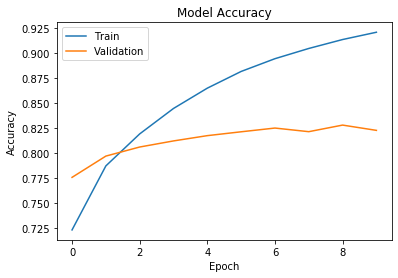

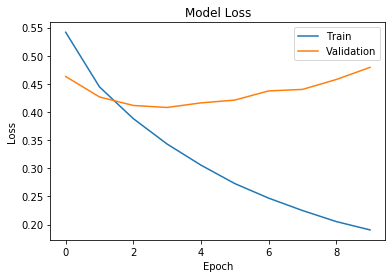

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
USE_left (Lambda)               (None, 512)          0           input_3[0][0]                    
__________________________________________________________________________________________________
USE_right (Lambda)              (None, 512)          0           input_4[0][0]                    
____________________________________________________________________________________________

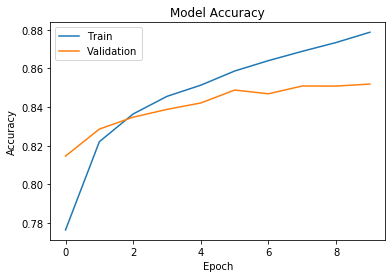

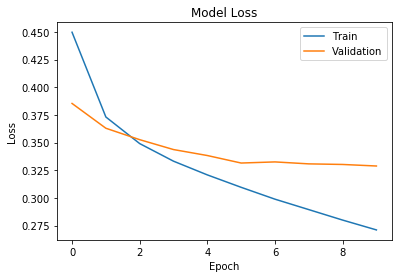

In [ ]:
# HIDDEN SIZE = 64 DROPOUT = [0.2, 0.1] recur DROPOUT = [0.2, 0.0]
model_bilstm = train_model(X_train, Y_train, X_validation, Y_validation, 'bilstm_model', n_hidden=50, epochs=15, batch_size=512, tune_embeds=True, dropout=[0.2, 0.0], recur_dropout=[0.0, 0.0])
model_bilstm_class = train_model(X_train, Y_train, X_validation, Y_validation, 'bilstm_class_model', n_hidden=50, epochs=10, batch_size=512, tune_embeds=True, dropout=[0.3, 0.0], recur_dropout=[0.0, 0.0])
model_use = train_model(X_train, Y_train, X_validation, Y_validation, 'use_model', n_hidden=512, epochs=10, batch_size=512, tune_embeds=True)

plot_results(model_bilstm, 'bilstm_model_50_embed')
plot_results(model_bilstm_class, 'bilstm_class_model_50_embed')
plot_results(model_use, 'use_model')

## Testando

Iremos testar nossa rede e comparar com os resultados do Universal Sentence Encoder que será usado na base da nossa rede no lugar do nosso sentece embedding.

Para refazer os testes basta treinar o modelo e substituir o nome da variavel model_name pelo nome do modelo salvo

In [ ]:
test_df['is_duplicate'] = test_df.index
test_result = list()
model_name=''
print()
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model = build_use(512)
    # model.load_weights('/content/' + model_name)
    model.load_weights('./' + model_name)
    i = 0
    for q1, q2 in zip(X_test['left'], X_test['right']):
        model.predict([q1, q2], verbose=0)
        predict_logits = predicts.argmax(axis=1)
        test_result.append((test_df.iloc[i]['id'], predict_logits))

with open('./' + model_name + '.csv', mode='w') as csv_file:
    field_names = ['id', 'is_duplicate']
    writer = csv.DictWriter(csv_file, fieldnames=field_names)
    writer.writerheader()
    for i in range(len(test_results)):
        writer.writerow({'id': test_result[0], 'is_duplicate': test_result[1]})